# Transfer Learning for Computer Vision

- **Finetuning the ConfNet**: Initialize the network woth a pretrained network. Rest of the training looks as usual.
- **ConvNet as fixed feature extractor**: Freeze the weights for all of the network except that of the final filly connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained

Train a model to classify ants and bees. 120 training images each for ants and bees. 75 validation images for each class.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion() # Interactive mode

## Load Data

In [2]:
# Data augmentation and normalization for training, normalization just for validation
data_transform = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = "data/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ["train", "val"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


### Visualize a few images

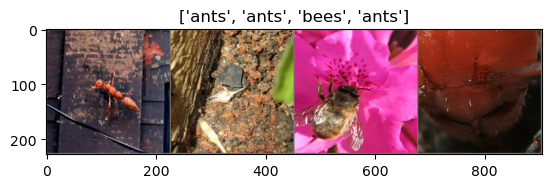

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}|{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and a validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train() # Set model to training mode
                else:
                    model.eval() # Set model to evaluation mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward, track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

                # Deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f"Training complete in {time_elapsed // 60:.0f}m  {time_elapsed % 60:.0f}s")
        print(f"Best val Acc: {best_acc:.4f}")

        model.load_state_dict(torch.load(best_model_params_path))

    return model

### Visualizing the model predictions

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"Predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.

In [6]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features

# Size of each output sample it set to 2. 
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and Evaluate

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0|24
----------
train Loss: 0.5611  Acc: 0.7172
val Loss: 0.2305  Acc: 0.9216

Epoch 1|24
----------
train Loss: 0.4370  Acc: 0.7951
val Loss: 0.2424  Acc: 0.9216

Epoch 2|24
----------
train Loss: 0.6476  Acc: 0.7418
val Loss: 0.4605  Acc: 0.7908

Epoch 3|24
----------
train Loss: 0.4623  Acc: 0.8156
val Loss: 0.2420  Acc: 0.8954

Epoch 4|24
----------
train Loss: 0.4148  Acc: 0.7992
val Loss: 0.2909  Acc: 0.8889

Epoch 5|24
----------
train Loss: 0.3831  Acc: 0.8197
val Loss: 0.2006  Acc: 0.9346

Epoch 6|24
----------
train Loss: 0.6302  Acc: 0.7828
val Loss: 0.2015  Acc: 0.8954

Epoch 7|24
----------
train Loss: 0.3852  Acc: 0.8566
val Loss: 0.2965  Acc: 0.8758

Epoch 8|24
----------
train Loss: 0.3445  Acc: 0.8484
val Loss: 0.1997  Acc: 0.9216

Epoch 9|24
----------
train Loss: 0.3285  Acc: 0.8566
val Loss: 0.2880  Acc: 0.8954

Epoch 10|24
----------
train Loss: 0.3470  Acc: 0.8361
val Loss: 0.2532  Acc: 0.9020

Epoch 11|24
----------
train Loss: 0.3184  Acc: 0.8689
val Loss:

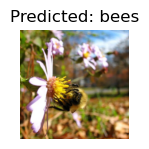

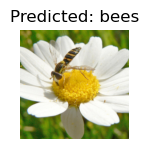

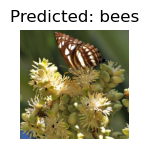

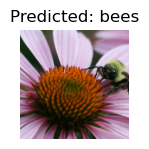

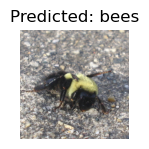

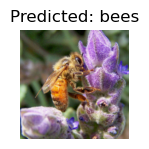

In [8]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

Freeze all the network except the final layer.

In [9]:
model_conv = models.resnet18(weights="IMAGENET1K_V1")
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and Evaluate

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0|24
----------
train Loss: 0.6009  Acc: 0.6967
val Loss: 0.3657  Acc: 0.8497

Epoch 1|24
----------
train Loss: 0.5021  Acc: 0.7787
val Loss: 0.2163  Acc: 0.9412

Epoch 2|24
----------
train Loss: 0.3926  Acc: 0.8402
val Loss: 0.2070  Acc: 0.9150

Epoch 3|24
----------
train Loss: 0.4647  Acc: 0.7787
val Loss: 0.1941  Acc: 0.9216

Epoch 4|24
----------
train Loss: 0.3467  Acc: 0.8279
val Loss: 0.3734  Acc: 0.8431

Epoch 5|24
----------
train Loss: 0.5457  Acc: 0.7664
val Loss: 1.0300  Acc: 0.6928

Epoch 6|24
----------
train Loss: 0.7446  Acc: 0.7131
val Loss: 0.4032  Acc: 0.8497

Epoch 7|24
----------
train Loss: 0.4889  Acc: 0.7869
val Loss: 0.2049  Acc: 0.9281

Epoch 8|24
----------
train Loss: 0.4426  Acc: 0.8197
val Loss: 0.1983  Acc: 0.9412

Epoch 9|24
----------
train Loss: 0.3640  Acc: 0.8361
val Loss: 0.1948  Acc: 0.9346

Epoch 10|24
----------
train Loss: 0.3156  Acc: 0.8607
val Loss: 0.2056  Acc: 0.9346

Epoch 11|24
----------
train Loss: 0.3788  Acc: 0.8238
val Loss:

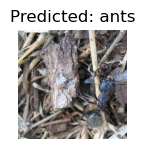

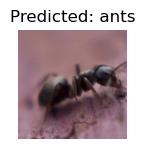

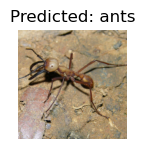

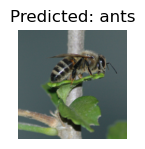

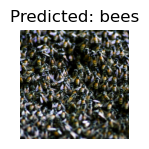

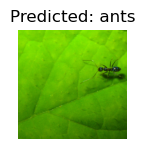

In [11]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

In [12]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transform["val"](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2, 2, 1)
        ax.axis("off")
        ax.set_title(f"Predicted: {class_names[preds[0]]}")
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

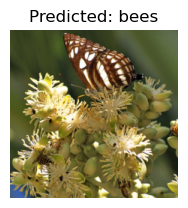

In [13]:
visualize_model_predictions(
    model_conv,
    img_path="data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg"
)

plt.ioff
plt.show()